# ベクトルのスカラ積（内積）のサンプル

簡単な例（ベクトルのスカラ積）を通してiMulveryを使った次のような開発の流れを体験するためのサンプルです．

 1. Observableの定義
 1. Mulveryを用いた処理の記述
 1. `sample_input` 機能を用いた動作レベル検証
 1. `display` 機能を用いたハードウェアの確認
 1. `optimizer` 機能を用いたハードウェアの最適化

## iMulveryを利用する準備

iMulveryは，単に `require` するだけで利用できます．
MulveryもiMulveryもRubyやjupyter-notebookには手を加えていないので，既存のirbやjupyter-notebookですぐに利用できます．

In [1]:
require '../lib/imulvery'

true

## Observableの定義

データ源となるようなObservableを定義します．  
メモリのデータを利用する `from_array` やInputポートを利用する `from_in` などのジェネレータが用意されています．

In [2]:
ob_1 = Mulvery::Observable.from_input
ob_2 = Mulvery::Observable.from_input

#<Mulvery::InputBus:0x00005613f7fcc630 @data_path=[#<Mulvery::Observable::ObservableNode:0x00005613f7fccc48 @type=:source, @info={:type=>:from_in}, @reg=0>]>

## 処理の記述

Mulveryの記法（Rx）に基づいて処理を記述していきます．  
このコードでは，結果の計算が終わり次第（＝非同期に）変数 `actual` がその結果で更新されます．

In [3]:
actual = 0
result = ob_1
  .zip(ob_2)
  .reduce do |reg, d|
    reg += d[0] * d[1]
  end
  .subscribe do |data|
    actual = data
  end

#<Mulvery::InputBus:0x00005613f7fccf90 @data_path=[#<Mulvery::Observable::ObservableNode:0x00005613f7fcd008 @type=:source, @info={:type=>:from_in}, @reg=0>, #<Mulvery::Observable::ObservableNode:0x00005613f7f1c848 @type=:zip, @info={:observables=>[#<Mulvery::InputBus:0x00005613f7fcc630 @data_path=[#<Mulvery::Observable::ObservableNode:0x00005613f7fccc48 @type=:source, @info={:type=>:from_in}, @reg=0>]>]}, @reg=0>, #<Mulvery::Observable::ObservableNode:0x00005613f7f1c2d0 @type=:reduce, @info={:lambda_abs=>#<Proc:0x00005613f7f1c708@<main>:3>}, @reg=0>, #<Mulvery::Observable::ObservableNode:0x00005613f7f1c208 @type=:subscribe, @info={:lambda_abs=>#<Proc:0x00005613f7f1c2a8@<main>:6>}, @reg=0>]>

## 動作レベル検証

先程定義した `result` observableが正しい結果を出力するか検証します．  
`from_in` で生成したObservableはサンプル入力をサポートしているので，これを利用します．

まずはRubyを使って普通に計算してみます．

In [4]:
array_1 = [1, 2, 3, 4]
array_2 = [5, 6, 7, 8]

expected = array_1
  .zip(array_2)
  .reduce(0) do |reg, d|
    reg += d[0] * d[1]
  end

print "Expected: #{expected}\n"
print "Actual: #{actual}" # まだ計算結果はアップデートされていない

Expected: 70
Actual: 0

今度はObservablesにサンプルを入力して計算させてみます．

In [8]:
ob_1.sample_input_from_array(array_1)
ob_2.sample_input_from_array(array_2)
ob_1.execute # ここでActualがアップデートされる

print "Expected: #{expected}\n"
print "Actual: #{actual}\n"

Expected: 70
Actual: 70


## displayを用いたハードの確認

iMulveryの特色である `display` の機能を用いて生成されるハードウェアをビジュアライズします．  
最適化を施さない状態では，Mulveryの記述が素直に表示されます．

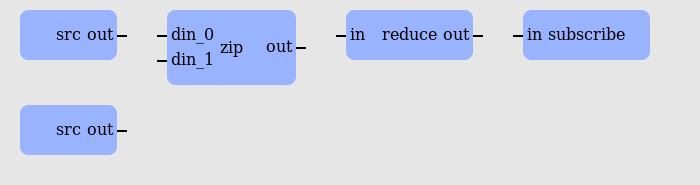

#<CZTop::Socket::PUB:0x5613f876ec80 last_endpoint="tcp://127.0.0.1:35733">

In [6]:
bd = IMulvery::BlockDiagram.from_observable(result)
IRuby.display(bd.build_map, mime: "image/png")

## optimizerを用いたチューニング

Mulveryの新機能である `optimizer` を用いてハードウェアのチューニングを行います．  
といってもこのサンプルは既に十分に最適化されているので，できることはありません．

In [7]:
# result.optimize(Mulvery::Optimizers::pipeline)